## Import Module

The following code imports the necessary code to run the code in the rest of this Colaboratory.

In [0]:
import numpy as np
import pandas as pd 
import nltk
import re

import nltk
from nltk.stem import LancasterStemmer

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB

import itertools
import matplotlib.pyplot as plt
from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Define the replace_puncts, strip_chars, and puncts

this list and arrays are going to be used in defining the functions

In [0]:
stemmer = LancasterStemmer()

replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']

## Define functions that clean, lemmatize, process text, and remove stem words from text

The following code defines three functions:

  * `clean_text`, which convert word to lower case and replace some characters
  * `stem`, steam each word in the given text
  * `text_processing`, which incorporate all the function above into one function that will be used to process text later

In [0]:
def clean_text(x):
    x = str(x)
    x = x.lower()
    x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", x)
    for k, v in replace_puncts.items():
        x = x.replace(k, f' {v} ')
        
    for punct in strip_chars:
        x = x.replace(punct, ' ') 
    
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
        
    x = x.replace(" '", " ")
    x = x.replace("' ", " ")
   
    return x

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

def text_processing(X):
    X=X.apply(clean_text)
    X=X.apply(stemming)
    return X

## Loading Dataset

in this project, we use data from Kaggle :  [Fake and Real News Dasaset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset) 


In [4]:
fake_dataset_url = 'https://raw.githubusercontent.com/Bangkit-2-Jakarta-Team/Fake-News-Detection/master/Datasets/Fake.csv'
true_dataset_url='https://raw.githubusercontent.com/Bangkit-2-Jakarta-Team/Fake-News-Detection/master/Datasets/True.csv'

df_fake = pd.read_csv(fake_dataset_url)
df_true = pd.read_csv(true_dataset_url)
df_fake['is_true'] = "FAKE"
df_true['is_true'] = "REAL"

# make ratio of true and fake dataset is same
df_length = min(len(df_fake), len(df_true))
df_fake = df_fake[:df_length]
df_true = df_true[:df_length]

#Merge two dataframe into one
df_data = pd.concat([df_fake,df_true])

#Randomizing data sequence to scatter data
df_data = shuffle(df_data).reset_index(drop=True)

#Showing sample
df_data.sample(5)

,title,text,subject,date,is_true
26274,Hillary Puts Trump To Shame With Powerful Res...,After a white nationalist rally in Charlottesv...,News,"August 13, 2017",FAKE
620,"Trump, top defense officials, discuss North Ko...",WASHINGTON (Reuters) - U.S. President Donald T...,worldnews,"October 10, 2017",REAL
15984,WATCH JUDGE ORDER PUNK WEARING “POLICE LIE” T-...,The hate for our law enforcement is at an all ...,politics,"May 18, 2015",FAKE
4142,Trump says: 'Most likely I won't be doing the ...,(Reuters) - U.S. Republican presidential candi...,politicsNews,"January 26, 2016",REAL
21972,Je Suis HYPOCRITES: FREE SPEECH IS EMBRACED WH...,"Sooo when terrorists attack Je Suis Charlie, a...",politics,"May 5, 2015",FAKE


## The Features Used

In [0]:
x = df_data['text']
y = df_data['is_true']

## Generating Wordcloud that show most common word in News Text

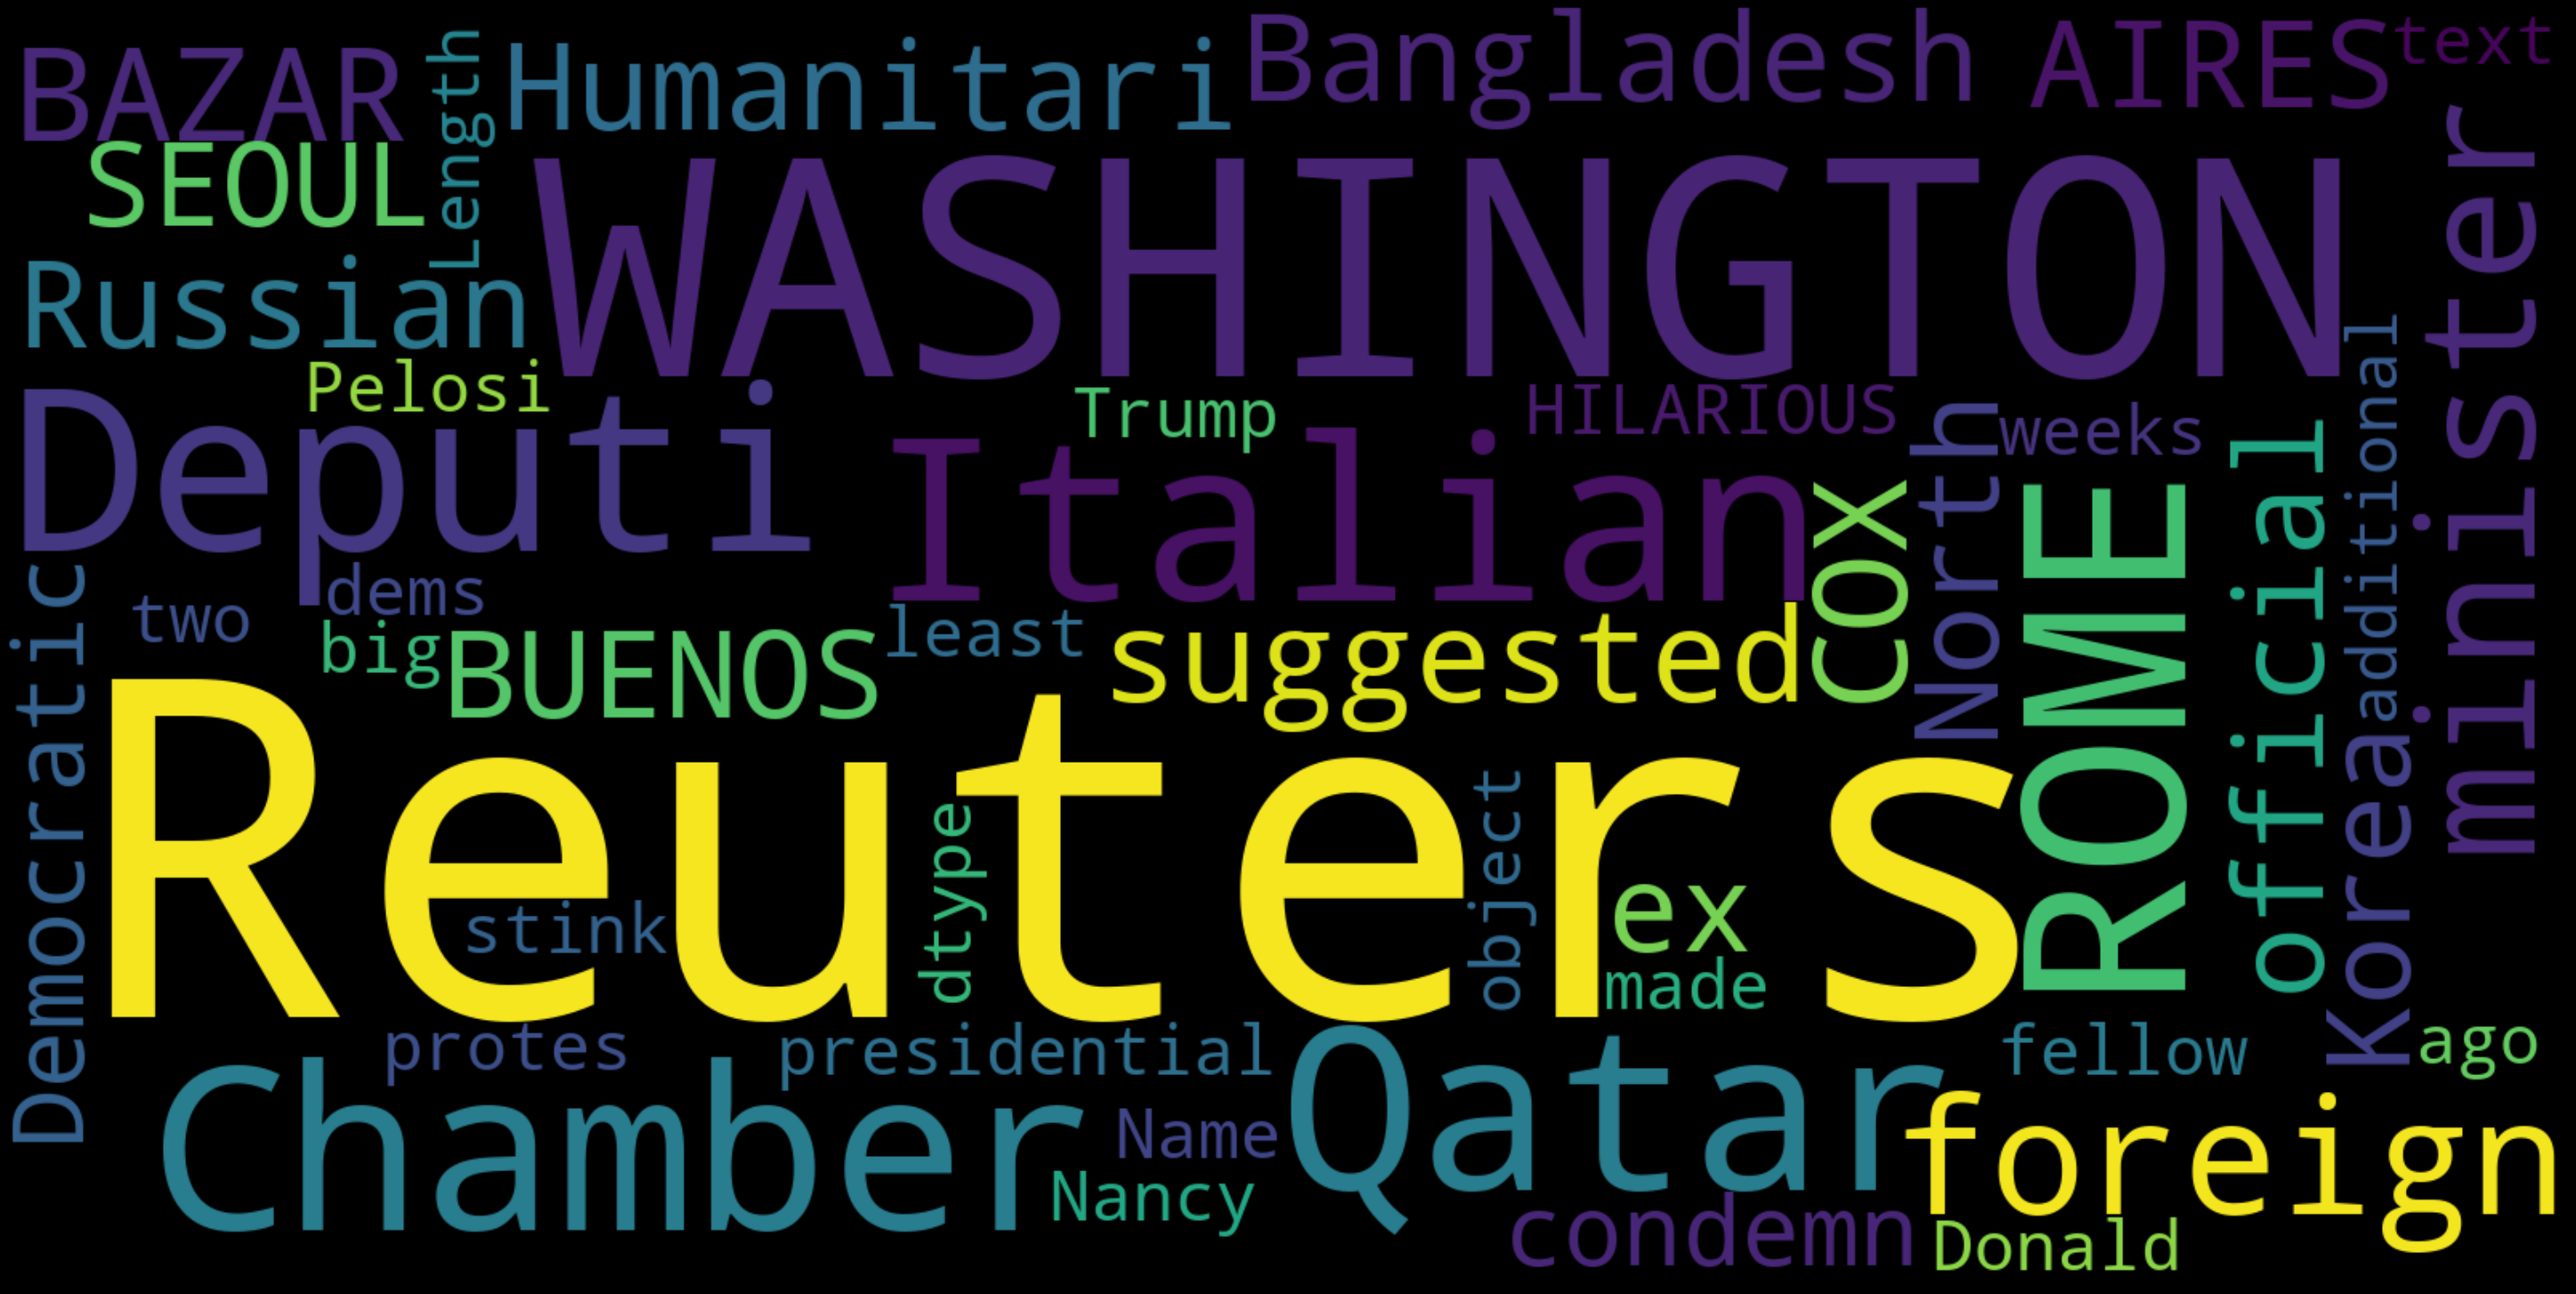

In [6]:
#Counting Unique word to generate WordCloud
text_wc = x
wordcloud= WordCloud(
    width =1600,
    height = 800,
    background_color='black',
    stopwords=STOPWORDS).generate(str(text_wc))
fig = plt.figure(
    figsize = (40,30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Clean title feature text

In [0]:
#Clean data using text_processing() function
clean_x = text_processing(x)

## Split train and test dataset

In [0]:
x_train, x_test, y_train, y_test = train_test_split(clean_x, y, test_size=0.3, random_state = 42)

## TFIDF Vectorizer

In [0]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(x_test)

## Define plot function

In [0]:
def plot_confusion_matrix(cm, classes, name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title+" "+name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Train SVM Model

In [25]:
linear_clf = PassiveAggressiveClassifier()
linear_clf.fit(tfidf_train, y_train)

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)

## Train NB Model

In [26]:
clf = MultinomialNB()
clf.fit(tfidf_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Evaluate model accuracy

In [0]:
# SVM
predSVM = linear_clf.predict(tfidf_test)
scoreSVM = metrics.accuracy_score(y_test, predSVM)

# NB
predNB = clf.predict(tfidf_test)
scoreNB = metrics.accuracy_score(y_test, predNB)

## Result

In [28]:
print("accuracy SVM:   %0.3f" % scoreSVM)
print("accuracy NB:   %0.3f" % scoreNB)

accuracy SVM:   0.991
accuracy NB:   0.932


## Visualization SVM


Confusion matrix, without normalization


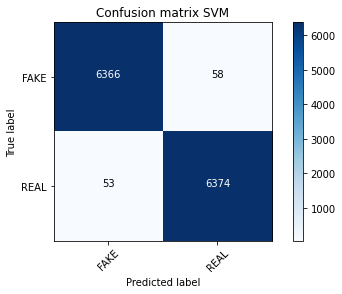

In [29]:
cmSVM = metrics.confusion_matrix(y_test, predSVM, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cmSVM, ['FAKE', 'REAL'], "SVM")

## Visualization NB

Confusion matrix, without normalization


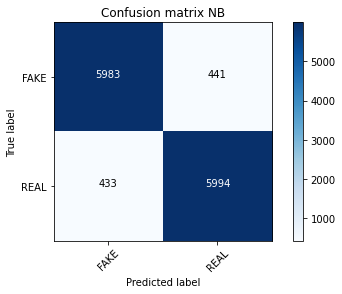

In [30]:
cmNB = metrics.confusion_matrix(y_test, predNB, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cmNB, ['FAKE', 'REAL'], "NB")

## Comparison

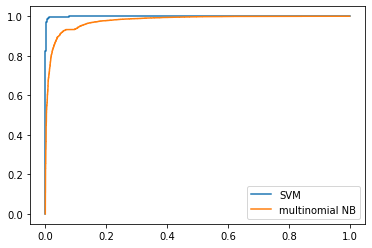

In [31]:
plt.figure(0).clf()

for model, name in [ (linear_clf, 'SVM'),
                     (clf, 'multinomial NB')]:
    if 'multinomial' in name:
        pred = model.predict_proba(tfidf_test)[:,1]
    else: 
        pred = model.decision_function(tfidf_test)
    fpr, tpr, thresh = metrics.roc_curve(y_test.values, pred, pos_label='REAL')
    plt.plot(fpr,tpr,label="{}".format(name))

plt.legend(loc=0)